In [15]:
from C4I import benchmarks, clustering, evaluation, investment, risk_factors, utils
import pandas as pd
import numpy as np
import pickle

Source


In [24]:
def An_Unsupervised_Learning_Framework(X, n_pcs, len_fold, n_win,temp_path=None,
                                scaler_pre='MinMax', coll_threshold=0.5, SEED=1,
                                lasso_fold=5, min_rfs=2, max_rfs=4, n_round=3,
                                scaler='Standard',
                                opt_hyper_port={'maxiter':200, 'disp':True},
                                port_select=3, verbose=True):
    '''
    INPUT:
        X: DataFrame, contains assets daily prices
        n_pcs: number of Principal Components to consider
        len_fold: int, length of each fold
        n_win: int, number of windows for the pooled regression
        temp_path: None or str, path for temp savings. If None, there are no
            temp savings. Default=None
        scaler_pre: str representing the scaler to use in preprocessing, either
            'Standard' or 'MinMax'. Other values will result in no scaling.
            Default='Standard'
        coll_threshold: float, correlation threshold for collinearity filter
        SEED: int, seed to set random values
        lasso_fold: int, number of folds for the cross validation. Default = 5
        min_rfs: int, minimum number of risk factors to be saved. Default = 2
        max_rfs: int, maximum number of risk factors to be saved. Default = 4
        n_round: int, number of decimals considered (if <=0, no round).Default=3
        scaler: str representing the scaler to use, either 'Standard' or
            'MinMax'. Other values will result in no scaling. Default='Standard'
        opt_hyper_port: dcit, hyperparameters for the minimizer, containing two
            keys: 'maxiter' and 'disp'. Default={'maxiter':200, 'disp':True}
        port_select: int, number of portfolios to select. Default=3
        verbose: bool, manages the verbosity. Default=True
    OUTPUT:
        target_portfolios: list, containing weights of the optimal portfolio
    '''
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    
    #----- From prices to returns
    X.index = pd.to_datetime(X.index)
    # Monthly returns
    XM = utils.DailyPrice2MonthlyReturn(X)
    # Daily returns
    XD = utils.DailyPrice2DailyReturn(X)
    # Scale data
    if scaler_pre == 'Standard':
        XD = pd.DataFrame( StandardScaler().fit_transform(XD.values),
                          index = XD.index, columns = XD.columns )
        XM = pd.DataFrame( StandardScaler().fit_transform(XM.values),
                          index = XM.index, columns = XM.columns )
    elif scaler_pre == 'MinMax':
        XD = pd.DataFrame( MinMaxScaler().fit_transform(XD.values),
                          index = XD.index, columns = XD.columns )
        XM = pd.DataFrame( MinMaxScaler().fit_transform(XM.values),
                          index = XM.index, columns = XM.columns )
    
    #----- Create Risk Factors
    if temp_path != None:
        try:
            PCs = pd.read_csv(f'{temp_path}/RiskFactors.csv', index_col=0)
            PCs.index = pd.to_datetime(PCs.index)
        except:
            PCs = risk_factors.CreateRiskFactors([XD, XM], n_pcs,
                                                 gran_names=['Daily','Monthly'],
                                                 threshold=coll_threshold,
                                                 SEED=SEED)
            PCs.to_csv(f'{temp_path}/RiskFactors.csv')
    else:
        PCs = risk_factors.CreateRiskFactors([XD, XM], n_pcs,
                                             gran_names=['Daily', 'Monthly'],
                                             threshold=coll_threshold,SEED=SEED)
    if verbose:
        print('Risk Factors successfully extracted!\n')

    #----- Apply Features Selection
    #Check if there are previous savings
    if temp_path != None:
        try:
            with open(f'{temp_path}/Saved_RFs.pickle','rb') as f:
                saved_rf = pickle.load(f)
        except:
            saved_rf = dict()
    else:
        saved_rf = dict()
    #Go on with features selection
    Grid = {'alpha':np.logspace(-11, -2, num=25, base=np.e),
        'tau':np.linspace(0.5, 1.5, 11)}
    
    cnt = 0
    for col in XD.columns[len(saved_rf.keys()):]:
        cnt += 1
        if verbose:
            print(f'Optimizing hyperparameters for asset {col}')
            print(f'Optimizing hyperparemeters for asset num {cnt} remaining {len(XD.columns[len(saved_rf.keys()):])}')

        flag, res = clustering.A_Lasso_Grid_Search(series=XD[col],
                                                   Exog=PCs.values,
                                                   grid=Grid,
                                                   n_fold=lasso_fold,
                                                   len_fold=len_fold,
                                                   min_rfs=min_rfs,
                                                   max_rfs=max_rfs,
                                                   scaler=scaler)
        #If the result is positive, store the hyperparameters
        if flag:
            saved_rf[col] = res
            if verbose:
                print(f'Optimization result: {res}')
        #Otherwise, make a new, more accurate search
        else:
            if res == -1:
                temp_Grid = {'alpha':np.logspace(-16, -11,num=25,base=np.e),
                            'tau':np.linspace(0.5, 1.5, 11)}
            elif res == 1:
                temp_Grid = {'alpha':np.logspace(-3, 3, num=25, base=np.e),
                            'tau':np.linspace(0.5, 1.5, 11)}
            else:
                temp_Grid = {'alpha':np.logspace(-11, -2,num=40,base=np.e),
                            'tau':np.linspace(0.5, 2, 20)}
            flag, res = clustering.A_Lasso_Grid_Search(series=XD[col],
                                                       Exog=PCs.values,
                                                       grid=temp_Grid,
                                                       n_fold=lasso_fold,
                                                       len_fold=len_fold,
                                                       min_rfs=min_rfs,
                                                       max_rfs=max_rfs,
                                                       scaler=scaler)
            if flag:
                saved_rf[col] = res
                if verbose:
                    print(f'Optimization result: {res}')
        if temp_path != None:
            with open(f'{temp_path}/Saved_RFs.pickle','wb') as f:
                pickle.dump(saved_rf, f)

    #----- Create Clustering
    #Create clusters
    clusters = clustering.Clustering(saved_rf)
    if verbose:
        print('Total clusters:')
        for n_clust, cluster in enumerate(clusters):
            print(f'Cluster {n_clust}, Risk factors: {cluster[0]},\
            Cluster Dimension: {len(cluster[1])}')
            print(f'Assets in the cluster: {cluster[1]}')
    #Save useful clusters
    clusters = clustering.UsefulClusters(clusters, saved_rf)
    if verbose:
        print('\nUseful clusters:')
        for n_clust, cluster in enumerate(clusters):
            print(f'Cluster {n_clust}, Risk factors: {cluster[0]}')
            print(f'Assets in the cluster: {cluster[1]}')

    #----- Investment Strategy
    target_portfolios = investment.Create_Portfolios(XD=XD, Exog=PCs.values,
                                        clusters=clusters,
                                        target_function=utils.Expected_Sharpe,
                                        windows_number=n_win,
                                        scaler=scaler, opt_hyper=opt_hyper_port,
                                        port_to_select=port_select)
    #Adjust portfolios weight to obtain one output portfolio
    for port in target_portfolios:
        port[1] = port[1]/port_select
    return target_portfolios


Modified code

In [25]:
import matplotlib.pyplot as plt
import pandas as pd 

path = 'data'
base_line_data_path = 'Dataset'
X = pd.read_csv(f'{path}/close_price.csv', index_col="Date")
X.index = X.index.str[:10]
X.index = pd.to_datetime(X.index)
X.dropna(axis = 1, how = 'any', inplace = True)
XD = utils.DailyPrice2DailyReturn(X)

(1928, 100)

In [26]:
test_start_12fold = ['2022-09-01', 
                     '2022-10-01', 
                     '2022-11-01', 
                     '2022-12-01', 
                     '2023-01-01', 
                     '2023-02-01', 
                     '2023-03-01', 
                     '2023-04-01', 
                     '2023-05-01', 
                     '2023-06-01', 
                     '2023-07-01', 
                     '2023-08-01',
                     '2023-09-01']
                     

Training and Testing

In [19]:
portfolios = []
for i in range (12):
    X_test = XD[ XD.index >= test_start_12fold[i]]
    X_test_each_fold = X_test[ X_test.index < test_start_12fold[i + 1]]
    X_each_fold = X[ X.index < test_start_12fold[i] ]
    #Obtain portfolio value in the test set
    target_portfolio = An_Unsupervised_Learning_Framework(X_each_fold, n_pcs=7,
                                                            len_fold=42, n_win=50)
    portfolios.append(target_portfolio)

/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/100
34/34 [==============================] - 0s 933us/step - loss: 0.0682
Epoch 2/100
34/34 [==============================] - 0s 960us/step - loss: 0.0045
Epoch 3/100
34/34 [==============================] - 0s 991us/step - loss: 0.0035
Epoch 4/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 5/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 6/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 7/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 8/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 9/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 10/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 11/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 12/100
34/34 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 13/100
34/34 [===========

KeyboardInterrupt: 

In [32]:
import json
file = open('proposed_portfolios.txt','w')
for item in portfolios:
    json_string = json.dumps(item)
    file.write(json_string+"\n")
file.close()

Epoch 1/100
34/34 [==============================] - 0s 752us/step - loss: 0.0621
Epoch 2/100
34/34 [==============================] - 0s 687us/step - loss: 0.0043
Epoch 3/100
34/34 [==============================] - 0s 691us/step - loss: 0.0032
Epoch 4/100
34/34 [==============================] - 0s 770us/step - loss: 0.0029
Epoch 5/100
34/34 [==============================] - 0s 782us/step - loss: 0.0029
Epoch 6/100
34/34 [==============================] - 0s 794us/step - loss: 0.0027
Epoch 7/100
34/34 [==============================] - 0s 792us/step - loss: 0.0027
Epoch 8/100
34/34 [==============================] - 0s 787us/step - loss: 0.0026
Epoch 9/100
34/34 [==============================] - 0s 800us/step - loss: 0.0025
Epoch 10/100
34/34 [==============================] - 0s 787us/step - loss: 0.0026
Epoch 11/100
34/34 [==============================] - 0s 776us/step - loss: 0.0025
Epoch 12/100
34/34 [==============================] - 0s 789us/step - loss: 0.0024
Epoch 13/100


[[['ADBE', 'AMD', 'AMGN', 'ADSK'],
  array([ 0.05183136,  0.12715399,  0.007353  , -0.14699499])],
 [['MMM',
   'AOS',
   'ADM',
   'AAP',
   'AFL',
   'ALL',
   'AIG',
   'AZO',
   'BKR',
   'BWA',
   'CBRE',
   'SCHW'],
  array([-9.65643561e-04, -1.54303955e-02,  6.70366849e-02, -1.76866088e-03,
         -8.46889822e-02, -1.63587961e-04,  2.35586188e-02, -3.58729271e-02,
         -2.39167859e-02, -1.47144311e-02,  6.52117584e-02, -4.85692737e-06])],
 [['ACN',
   'ATVI',
   'ALGN',
   'GOOGL',
   'GOOG',
   'ANSS',
   'AAPL',
   'ANET',
   'BIIB',
   'BR'],
  array([-9.73903708e-02,  9.03421624e-03, -4.13186640e-02,  3.09414968e-06,
          1.65096621e-06,  1.06029065e-01, -3.21183880e-07,  9.23857332e-08,
          6.99740918e-02, -9.58195105e-03])]]

In [34]:
 #Evaluate results
port_test_12fold = list()
for i in range (12):
    X_test = XD[ XD.index >= test_start_12fold[i]]
    X_test_each_fold = X_test[ X_test.index < test_start_12fold[i + 1]]
    X_each_fold = X[ X.index < test_start_12fold[i]]
    port_test = investment.Investment(X_test_each_fold, portfolios[i], initial_capital=1000)
    print('\nProposed strategy for ' + str(i + 1) + ' fold')
    port_test_12fold.append(port_test)
    evaluation.Strategy_Evaluation(port_test)
    print('\n')

[[[['ADBE', 'AMD', 'AMGN', 'ADSK'],
   array([ 0.05183136,  0.12715399,  0.007353  , -0.14699499])],
  [['MMM',
    'AOS',
    'ADM',
    'AAP',
    'AFL',
    'ALL',
    'AIG',
    'AZO',
    'BKR',
    'BWA',
    'CBRE',
    'SCHW'],
   array([-9.65643561e-04, -1.54303955e-02,  6.70366849e-02, -1.76866088e-03,
          -8.46889822e-02, -1.63587961e-04,  2.35586188e-02, -3.58729271e-02,
          -2.39167859e-02, -1.47144311e-02,  6.52117584e-02, -4.85692737e-06])],
  [['ACN',
    'ATVI',
    'ALGN',
    'GOOGL',
    'GOOG',
    'ANSS',
    'AAPL',
    'ANET',
    'BIIB',
    'BR'],
   array([-9.73903708e-02,  9.03421624e-03, -4.13186640e-02,  3.09414968e-06,
           1.65096621e-06,  1.06029065e-01, -3.21183880e-07,  9.23857332e-08,
           6.99740918e-02, -9.58195105e-03])]]]

In [35]:
file = open('proposed_model_and_statistics.txt','w')
for item in port_test_12fold:
	file.write(str(item)+"\n")
file.close()


Proposed strategy for 1 fold
Percentage Profit: -0.197%
Profit Factor: 0.891
Percentage Drawdown: 1.011%
Recovery Factor: -0.194
Sharpe Ratio: -0.538
Sortino Ratio: -1.157


/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/C4I/utils.py:66: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  dfV[0] = initial_capital
/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/C4I/utils.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfV[i] = dfV[i-1]*(1+dfV[i])
/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/C4I/utils.py:68: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

In [ ]:
#Evaluate benchmark
min_test_12fold = list()
for i in range (12):
    X_test = XD[ XD.index >= test_start_12fold[i]]
    X_test_each_fold = X_test[ X_test.index < test_start_12fold[i + 1]]
    X_each_fold = X[ X.index < test_start_12fold[i]]
    XD_each_fold = utils.DailyPrice2DailyReturn(X_each_fold)
    min_test = benchmarks.Minimal_Variance_Portfolio(XD_each_fold, X_test_each_fold)
    print('Minimal Variance Portfolio for ' + str(i + 1) + ' fold')
    evaluation.Strategy_Evaluation(min_test)
    min_test_12fold.append(min_test)
    evaluation.Strategy_Evaluation(min_test)
    print('\n')

In [ ]:
file = open('min_test_model_and_statistics_last_2.txt','w')
for item in min_test_12fold:
    file.write(str(item)+"\n")
file.close()

In [ ]:
mean_var_test_12fold = list()
for i in range (12):
    print('Start New')
    X_test = XD[ XD.index >= test_start_12fold[i]]
    X_test_each_fold = X_test[ X_test.index < test_start_12fold[i + 1]]
    X_each_fold = X[ X.index < test_start_12fold[i]]
    XD_each_fold = utils.DailyPrice2DailyReturn(X_each_fold)
    print('Start optimization')
    mean_var_test = benchmarks.Mean_Variance_Portfolio(XD_each_fold, X_test_each_fold)
    print('Mean-Variance Portfolio for ' + str(i + 1) + ' fold')
    mean_var_test_12fold.append(mean_var_test)
    print('\n')

In [ ]:
file = open('mean_var_test_model_and_statistics_last_1.txt','w')
for item in mean_var_test_12fold:
    file.write(str(item)+"\n")
file.close()

In [320]:
proposed = pd.read_csv('proposed_model_and_statistics.txt', header = None, sep = '\t')
i = 0
skip_rows = list()
for item in proposed[0]:
    if proposed[0][i] == "Name: Portfolio, dtype: float64" or proposed[0][i] == "Date":
        skip_rows.append(i)
    i = i + 1
proposed_deleted = pd.read_csv('proposed_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)
proposed_deleted[0] = pd.to_datetime(proposed_deleted[0])
proposed_deleted.columns =['Date', 'Return_proposed']
proposed_deleted = proposed_deleted.set_index('Date')
proposed_12_fold_read = list()
for i in range(12):
    month = i + 9
    if month > 12:
        month = month - 12
        
    temp = proposed_deleted.loc[
         proposed_deleted.index.month == month
    ]
    series = temp.iloc[:,0]
    temp = pd.Series(series, index = temp.index) 
    proposed_12_fold_read.append(temp)

/var/folders/wz/qlp895fd65v1n2c16h5m_1xr0000gn/T/ipykernel_74210/3134309762.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  proposed_deleted = pd.read_csv('proposed_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)


In [321]:
mean = pd.read_csv('mean_var_test_model_and_statistics.txt', header = None, sep = '\t')
i = 0
skip_rows = list()
for item in mean[0]:
    if mean[0][i] == "Name: Mean-Variance, dtype: float64" or mean[0][i] == "Date":
        skip_rows.append(i)
    i = i + 1
mean_deleted = pd.read_csv('mean_var_test_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)
mean_deleted[0] = pd.to_datetime(mean_deleted[0])
mean_deleted.columns =['Date', 'Return_mean']
mean_deleted = mean_deleted.set_index('Date')
mean_12_fold_read = list()
for i in range(12):
    month = i + 9
    if month > 12:
        month = month - 12
        
    temp = mean_deleted.loc[
         mean_deleted.index.month == month
    ]
    series = temp.iloc[:,0]
    temp = pd.Series(series, index = temp.index) 
    mean_12_fold_read.append(temp)

/var/folders/wz/qlp895fd65v1n2c16h5m_1xr0000gn/T/ipykernel_74210/705123581.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  mean_deleted = pd.read_csv('mean_var_test_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)


In [322]:
min = pd.read_csv('min_test_model_and_statistics.txt', header = None, sep = '\t')
i = 0
skip_rows = list()
for item in min[0]:
    if min[0][i] == "Name: Minimal Variance, dtype: float64" or min[0][i] == "Date":
        skip_rows.append(i)
    i = i + 1
min_deleted = pd.read_csv('min_test_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)
min_deleted[0] = pd.to_datetime(min_deleted[0])
min_deleted.columns =['Date', 'Return_min']
min_deleted = min_deleted.set_index('Date')
min_12_fold_read = list()
for i in range(12):
    month = i + 9
    if month > 12:
        month = month - 12
        
    temp = min_deleted.loc[
         min_deleted.index.month == month
    ]
    Series = temp.iloc[:,0]
    temp = pd.Series(Series, index = temp.index) 
    min_12_fold_read.append(temp)

/var/folders/wz/qlp895fd65v1n2c16h5m_1xr0000gn/T/ipykernel_74210/110965975.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  min_deleted = pd.read_csv('min_test_model_and_statistics.txt', header = None, sep = '    ', skiprows = skip_rows)


Plotting

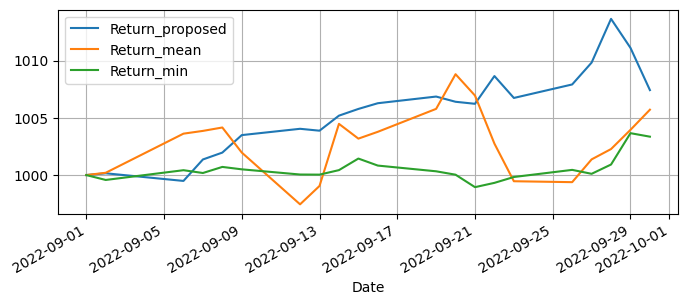

/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return self.major.locator()
/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/venv/lib/python3.9/site-packages/matplotlib/a

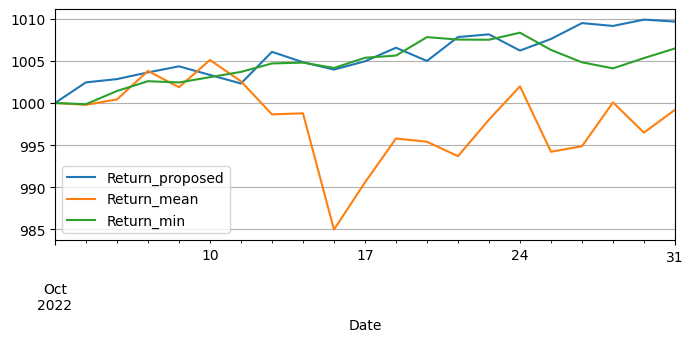

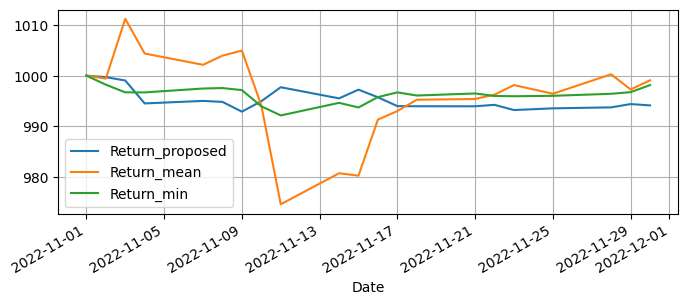

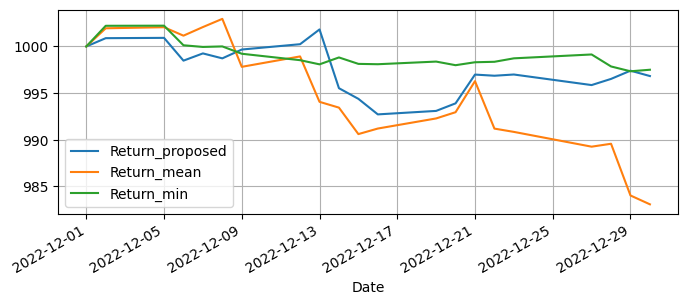

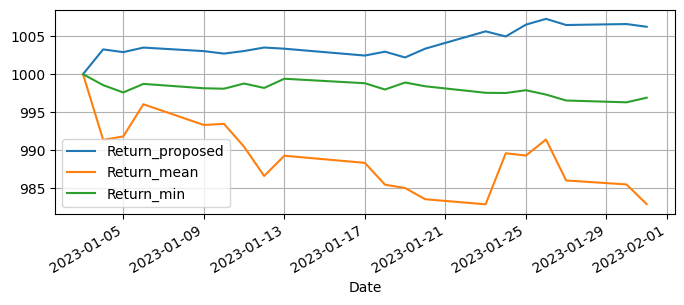

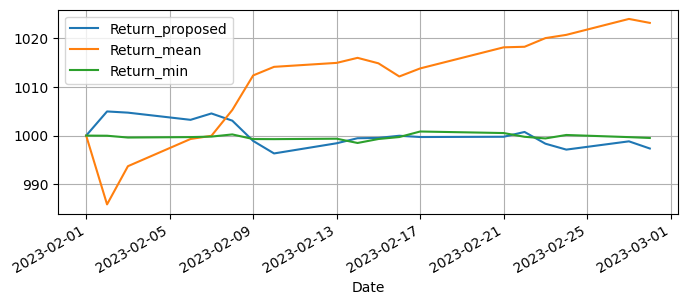

/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return self.major.locator()
/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/venv/lib/python3.9/site-packages/matplotlib/a

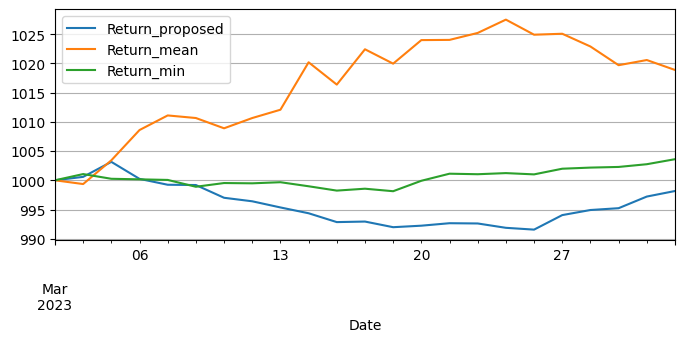

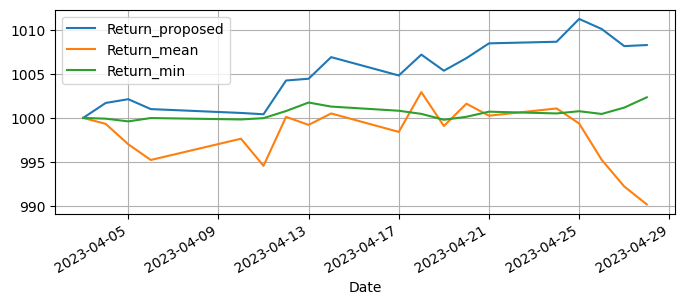

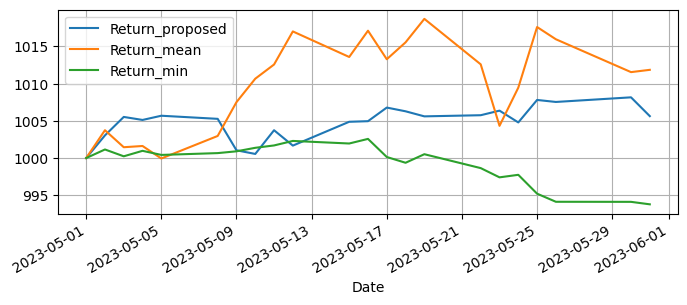

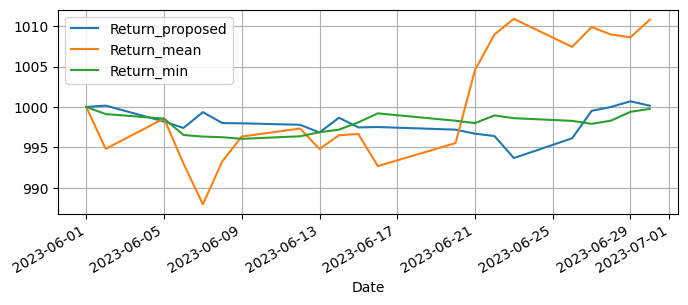

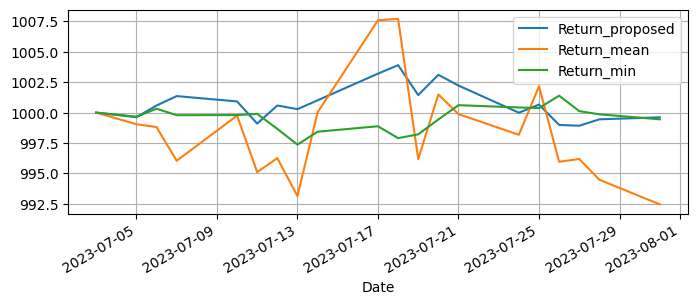

/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/venv/lib/python3.9/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/venv/lib/python3.9/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return self.major.locator()
/Users/zhangjianan/Documents/GitHub/ST5188_StatisticalProject/venv/lib/python3.9/site-packages/matplotlib/a

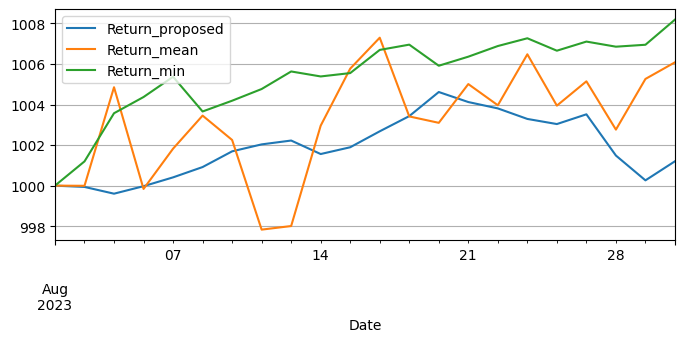

In [323]:
#Plot the results
for i in range (12):
    proposed_12_fold_read[i].plot(figsize=(8,3))
    mean_12_fold_read[i].plot(figsize=(8,3))
    min_12_fold_read[i].plot(figsize=(8,3))
    plt.grid()
    plt.legend()
    plt.show()

In [328]:
for i in range (12):
    print("fold " + str(i + 1))
    print("\n Proposed method \n")
    evaluation.Strategy_Evaluation(proposed_12_fold_read[i])
    print("\n Mean Variance method \n")
    evaluation.Strategy_Evaluation(mean_12_fold_read[i])
    print("\n Min Variance method \n")
    evaluation.Strategy_Evaluation(min_12_fold_read[i])
    print("\n")
    print("\n")

fold 1

 Proposed method 

Percentage Profit: 0.742%
Profit Factor: 1.773
Percentage Drawdown: 0.614%
Recovery Factor: 1.192
Sharpe Ratio: 3.513
Sortino Ratio: 4.294

 Mean Variance method 

Percentage Profit: 0.571%
Profit Factor: 1.328
Percentage Drawdown: 0.935%
Recovery Factor: 0.606
Sharpe Ratio: 1.785
Sortino Ratio: 2.442

 Min Variance method 

Percentage Profit: 0.335%
Profit Factor: 1.747
Percentage Drawdown: 0.249%
Recovery Factor: 1.343
Sharpe Ratio: 3.185
Sortino Ratio: 9.329




fold 2

 Proposed method 

Percentage Profit: 0.966%
Profit Factor: 2.177
Percentage Drawdown: 0.209%
Recovery Factor: 4.587
Sharpe Ratio: 5.147
Sortino Ratio: 10.085

 Mean Variance method 

Percentage Profit: -0.081%
Profit Factor: 0.977
Percentage Drawdown: 2.003%
Recovery Factor: -0.04
Sharpe Ratio: -0.129
Sortino Ratio: -0.141

 Min Variance method 

Percentage Profit: 0.648%
Profit Factor: 2.184
Percentage Drawdown: 0.42%
Recovery Factor: 1.53
Sharpe Ratio: 5.011
Sortino Ratio: 6.966




fold